In [1]:
import re
import torch
import utils
import random

import numpy as np
import pandas as pd

from collections import defaultdict, Counter
from minicons import cwe
from sklearn.decomposition import PCA
from string import Template
from torch.utils.data import DataLoader
from tqdm import tqdm

/scratch/miniconda3/envs/dev/lib/python3.11/site-packages/transformers/utils/hub.py:105: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [ ]:
vlm = True

data_path = "../data/gqa_entities"

lemma_path = f"{data_path}/gqa-lemmas-annotated.csv"

lexicon = defaultdict(dict)
lemmas = utils.read_csv_dict(lemma_path)
lemmas = [l for l in lemmas if l["remove"] not in ["?", "1"]]
for entry in lemmas:
    lexicon[entry["lemma"]] = entry

lexicon["sports equiment"] = {
    "lemma": "sports equiment",
    "singular": "sports equiment",
    "plural": "sports equiment",
    "article": "sports equiment",
    "taxonomic_phrase": "are a type of",
    "novel_property_is": "",
    "novel_property_have": "",
    "generic": "p",
    "remove": "",
}

lexicon = dict(lexicon)

data = utils.read_csv_dict("../data/gqa_dataset/final_model_outputs_9_types.csv")
model_ids = defaultdict(list)

print(len(data))

if vlm:
    ids = utils.read_csv_dict("../data/gqa_dataset/qwen-vl-base-correct-no.csv")
else:
    ids = utils.read_csv_dict("../data/gqa_dataset/qwen-lm-base-correct-no.csv")

ids = [i['question_id'] for i in ids]

print(len(ids))

question_types = [
    "existAttrC",
    "existAttrNotC",
    "existMaterialC",
    "existMaterialNotC",
]

if vlm:
    target = "vlm"
    vision = True
    model_type = "vision_text"
    model_id = "vlm_text_qwen2.5VL"
else:
    target = "lm"
    vision = False
    model_type = "text_only"
    model_id = "lm_Qwen2.5_7B_Instruct"

exists_data = [
    d
    for d in data
    if d["question_type"] in question_types
    and d["substitution_hop"] not in ["0", "-100"]
    and d["question_id"] in ids
]

92060
2067


In [3]:
pos_samples = defaultdict(list)
neg_samples = defaultdict(list)

# target_descriptions
for td in exists_data:
    hops = int(td['substitution_hop'])

    if hops > 0:
        # final_descriptions.append(td)
        pos_samples[td['original_arg']].append(td)
    elif hops < 0:
        neg_samples[td['original_arg']].append(td)
    else:
        print(hops)

pos_samples = dict(pos_samples)
neg_samples = dict(neg_samples)

In [4]:
# {k:len(v) for k,v in neg_samples.items()}

final_descriptions = []
for k, v in pos_samples.items():
    final_descriptions.extend(v)

random.seed(1024)

for k, v in neg_samples.items():
    sampled = random.sample(v, len(pos_samples[k]))

    final_descriptions.extend(sampled)

In [5]:
# len(final_descriptions)

def chat_template(sentence, tok, system=None, instruct=True, vision=False):
    """
    A function that applies the model's chat template to simulate
    an interaction environment.
    """
    if instruct == True:
        if system is None:
            if not vision:
                return tok.apply_chat_template(
                    [{"role": "user", "content": sentence}],
                    tokenize=False,
                    add_generation_prompt=True,
                )
            else:
                return tok.apply_chat_template(
                    [{"role": "user", "content": [{"type": "text", "text": sentence}]}],
                    tokenize=False,
                    add_generation_prompt=True,
                )
        else:
            try:
                if not vision:
                    return tok.apply_chat_template(
                        [
                            {"role": "system", "content": system},
                            {"role": "user", "content": sentence},
                        ],
                        tokenize=False,
                        add_generation_prompt=True,
                    )
                else:
                    try:
                        return tok.apply_chat_template(
                            [
                                {
                                    "role": "system",
                                    "content": [{"type": "text", "text": system}],
                                },
                                {
                                    "role": "user",
                                    "content": [{"type": "text", "text": sentence}],
                                },
                            ],
                            tokenize=False,
                            add_generation_prompt=True,
                        )
                    except:
                        try:
                            # print("second error")
                            return tok.apply_chat_template(
                                [
                                    {
                                        "role": "system",
                                        "content": system,
                                    },
                                    {
                                        "role": "user",
                                        "content": [{"type": "text", "text": sentence}],
                                    },
                                ],
                                tokenize=False,
                                add_generation_prompt=True,
                            )
                        except:
                            # print("third error")
                            return tok.apply_chat_template(
                                [
                                    {
                                        "role": "user",
                                        "content": f"{system} {sentence}",
                                    },
                                ],
                                tokenize=False,
                                add_generation_prompt=True,
                            )
            except:
                return tok.apply_chat_template(
                    [
                        {
                            "role": "user",
                            "content": [
                                {"type": "text", "text": f"{system} {sentence}"}
                            ],
                        },
                    ],
                    tokenize=False,
                    add_generation_prompt=True,
                )
    elif isinstance(instruct, Template):
        return instruct.substitute(system=system, sentence=sentence)
    else:
        return f"{system} {sentence} Answer:"

In [6]:
lm = cwe.CWE("Qwen/Qwen2.5-VL-7B-Instruct", device = "cuda:0")
# lm = cwe.CWE("Qwen/Qwen2.5-7B-Instruct", device = "cuda:0")

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [7]:
# stimuli = [(chat_template("This is a sentence", lm.tokenizer, system=None, instruct=True, vision=False), "assistant")]

stimuli = []

for entry in final_descriptions:
    # surface_form = f"Description: {entry['scene_description']} Question: In the scene, {entry['question'].lower()} Answer:"
    surface_form = entry['input']
    model_input = chat_template(surface_form, lm.tokenizer, vision=vision)
    sub_hop = int(entry["substitution_hop"])

    if sub_hop > 0:
        subs_type = "hypernym"
    elif sub_hop == 0:
        subs_type = "original"
    else:
        subs_type = "negative"

    stimuli.append(
        {
            "question_id": entry["question_id"],
            "substitution_hop": sub_hop,
            "subs_type": subs_type,
            "concept": entry["original_arg"],
            "input": model_input,
            "type": model_type,
            # "correct": entry["lm_"],
            # 'type': 'text_only',
            'correct': entry[model_id]
        }
    )

In [8]:
batches = DataLoader(stimuli, batch_size=1)

In [9]:
def extract_reps(lm, sentence_batch):
    padding_id = lm.tokenizer.pad_token_id
    encoded = lm.encode_text(sentence_batch)
    ids = encoded[0].tolist()

    idxes = [len([t for t in enc if t != padding_id]) - 1 for enc in ids]

    indexed = encoded[1][torch.arange(len(sentence_batch)), idxes]

    return indexed

In [10]:
reps = []

for batch in tqdm(batches):
    inputs = batch['input']

    embs = extract_reps(lm, inputs)
    # queries = batch['query']
    # paired = [(i, q) for i,q in zip(inputs, queries)]

    # embs = lm.extract_representation(paired)

    reps.extend(embs)

100%|██████████| 9106/9106 [32:34<00:00,  4.66it/s]  


In [11]:
reps_np = torch.stack(reps).numpy()

In [12]:
pca = PCA(n_components=3)
reps_pca = pca.fit(reps_np).transform(reps_np)

print(pca.explained_variance_ratio_)

[0.3433121  0.13555627 0.08989275]


In [15]:
# VLM: sum([0.34139356, 0.1334128 ]) 0.47480636
# LM: 
sum([0.3433121,  0.13555627]), sum([0.38439855, 0.12783593])

(0.47886837000000004, 0.51223448)

In [16]:
reps_pca

array([[ -0.7673187, -18.322353 , -14.271156 ],
       [-42.682537 , -20.135141 , -29.677605 ],
       [-38.6528   , -16.246296 , -24.034002 ],
       ...,
       [-18.190456 ,  46.688766 ,  -7.4056396],
       [ 12.373806 ,  33.937973 , -25.076561 ],
       [ 17.307686 ,  12.357784 ,  -0.8030862]], dtype=float32)

In [17]:
reps_pca_df = pd.DataFrame(reps_pca, columns=['x', 'y', 'z'])
stimuli_df = pd.DataFrame(stimuli)

joined = pd.concat([stimuli_df, reps_pca_df], axis = 1)

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: xlabel='x', ylabel='y'>

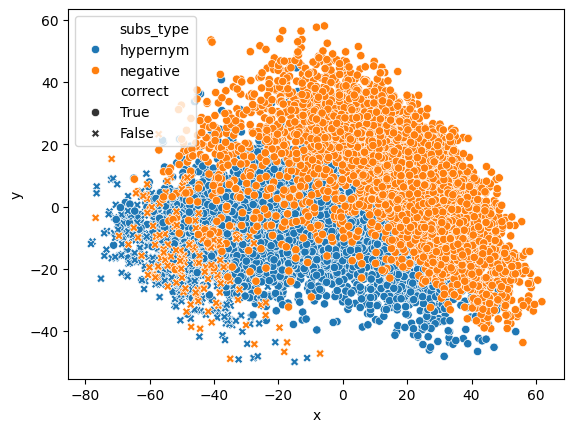

In [19]:
sns.scatterplot(data=joined, x="x", y="y", hue = "subs_type", style="correct")

In [20]:
joined.to_csv(f"../pca-data/qwen-2.5-7b-instruct-{model_type}.csv", index=False)
# joined.to_csv("../pca-data/qwen-2.5-7b-instruct-text-equal.csv", index=False)